# NAME: Varun Kumar Bhogoju
# WSUID: J893G242

## Assignment 4

### Importing Required Libraries

In [7]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_gan as tfgan
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

### Uploading Data

In [8]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()

Saving celeba_data_short.zip to celeba_data_short.zip


### CelebA dataset Preparation

In [9]:
import zipfile
import io
import os

# Get the name of the uploaded file
file_name = next(iter(uploaded))

# Define the extraction directory
extract_to_directory = '/content/sample_data/celeba_data_short'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_directory, exist_ok=True)

In [10]:
# Extract the file
with zipfile.ZipFile(io.BytesIO(uploaded[file_name]), 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print("File extracted successfully.")

File extracted successfully.


In [11]:
#Using face images from the celeba dataset, resized to 64x64
dataset = keras.utils.image_dataset_from_directory(
    "/content/sample_data/celeba_data_short/Celeba_data_short", label_mode=None, image_size=(64, 64), batch_size=32
)

Found 20256 files belonging to 1 classes.


In [13]:
#Rescaling the images to the [0-1] range
dataset = dataset.map(lambda x: x / 255.0)

In [14]:
dataset

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [15]:
test_list=os.listdir('/content/sample_data/celeba_data_short/Celeba_data_short')
len(test_list)

20256

### Plotting a sample image

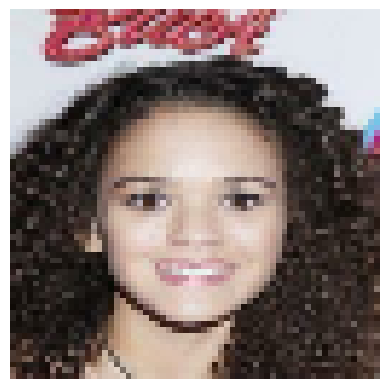

In [16]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### Discriminator Creation

In [18]:
#Creating Discriminator network which takes 64x64 image to a binary classification score
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)       

* A sequential model distinguishing real images from fake ones generated by the generator.
* A convolutional neural network.
* Used LeakyReLU activations, dropout layers, and a dense output layer.
* Output a single scalar representing the probability of an input being real or fake


### Generator Creation

In [17]:
#Creating Generator based on Discriminator, replacing Conv2D layers with Conv2DTranspose layers.

latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.BatchNormalization(),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                         

* A sequential model converting latent space vectors into 64x64x3 RGB images.
* A deep network with multiple deconvolutional layers.
* Used batch normalization and LeakyReLU activations.
* Output layer with a sigmoid activation function to generate images.


### Defining the GAN Model

* The GAN class combines the generator and discriminator.
* It overrides the train_step method to define the training process, which involves training the discriminator and generator in turns.
* The discriminator is trained on real images and fake images produced by the generator.
* The generator is trained to fool the discriminator by producing images that are classified as real.

In [19]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

### GAN Monitor Callback

This callback is used to save generated images at the end of each epoch, allowing you to visualize the progress of the generator.

In [20]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

### Training the GAN

* The GAN is compiled and trained for a specified number of epochs.
* It uses the Adam optimizer and binary cross-entropy loss.
* The GANMonitor callback is used to generate and save images after each epoch.

In [21]:
epochs = 50  # Checking the images for 50 Epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/50
633/633 [==============================] - 65s 86ms/step - d_loss: 0.4847 - g_loss: 1.5754
Epoch 2/50
633/633 [==============================] - 55s 86ms/step - d_loss: 0.5573 - g_loss: 1.4048
Epoch 3/50
633/633 [==============================] - 54s 86ms/step - d_loss: 0.6229 - g_loss: 1.1072
Epoch 4/50
633/633 [==============================] - 55s 86ms/step - d_loss: 0.6215 - g_loss: 1.2622
Epoch 5/50
633/633 [==============================] - 55s 87ms/step - d_loss: 0.6387 - g_loss: 1.1740
Epoch 6/50
633/633 [==============================] - 55s 86ms/step - d_loss: 0.6163 - g_loss: 1.2968
Epoch 7/50
633/633 [==============================] - 55s 86ms/step - d_loss: 0.6248 - g_loss: 1.2623
Epoch 8/50
633/633 [==============================] - 55s 87ms/step - d_loss: 0.6214 - g_loss: 1.1929
Epoch 9/50
633/633 [==============================] - 55s 86ms/step - d_loss: 0.6043 - g_loss: 1.3767
Epoch 10/50
633/633 [==============================] - 55s 86ms/step - d_loss: 0.6

### Displaying images

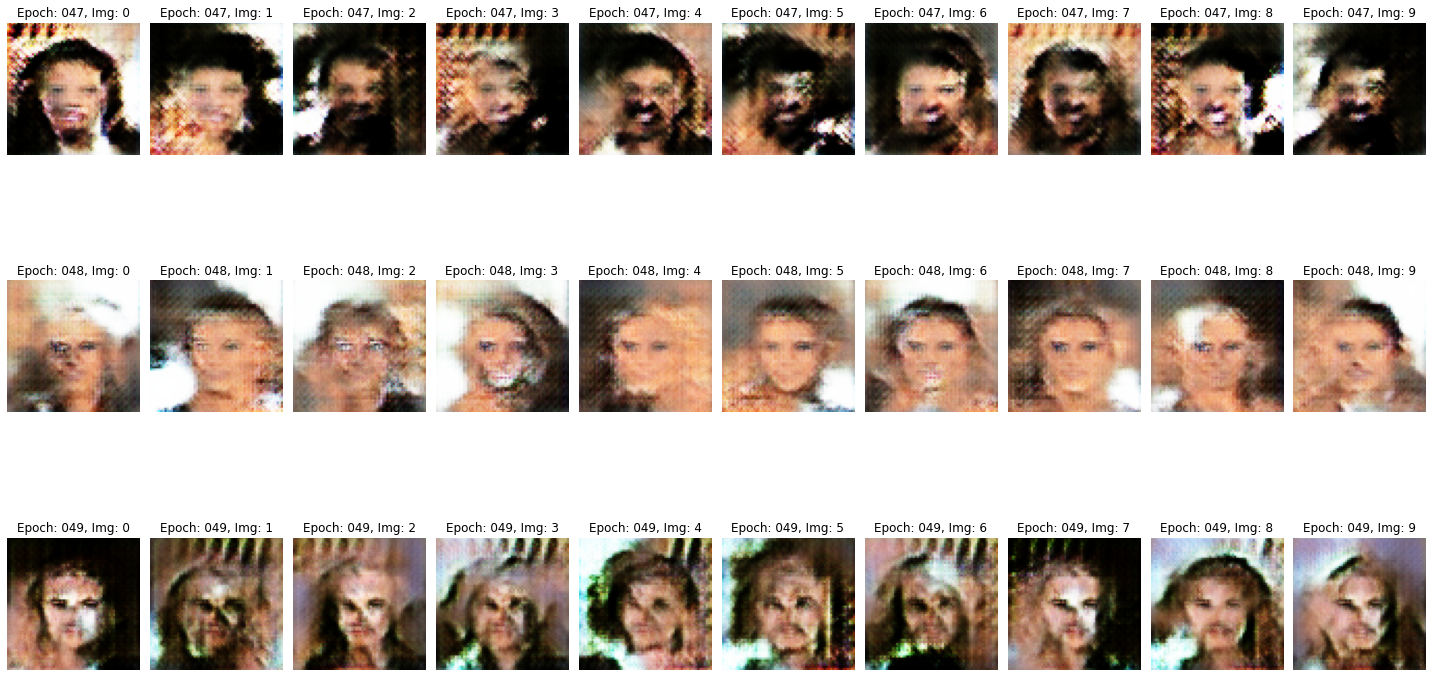

In [22]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def display_latest_images(directory, num_epochs, num_images_per_epoch):
    """
    Display the last `num_images_per_epoch` images from the last `num_epochs` epochs.
    """
    # List all files in the directory
    all_files = os.listdir(directory)
    image_files = [f for f in all_files if f.startswith('generated_img') and f.endswith('.png')]
    
    # Sort the files by epoch and image number
    sorted_files = sorted(image_files, key=lambda x: (int(x.split('_')[2]), int(x.split('_')[3].split('.')[0])))

    # Select the latest images
    latest_files = sorted_files[-num_epochs * num_images_per_epoch:]

    # Display the images
    plt.figure(figsize=(20, num_epochs * 4))
    for i, file in enumerate(latest_files):
        plt.subplot(num_epochs, num_images_per_epoch, i + 1)
        img = Image.open(os.path.join(directory, file))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Epoch: {file.split('_')[2]}, Img: {file.split('_')[3].split('.')[0]}")

    plt.tight_layout()
    plt.show()

# Directory where images are saved
image_directory = 'C:/Users/varun/Downloads/images1'  
display_latest_images(image_directory, num_epochs=3, num_images_per_epoch=10)


### Image Interpolation for 50 Epochs

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def interpolate_points(p1, p2, n_steps=10):
    """Interpolate between two points in latent space"""
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = []
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

def plot_images(images, n):
    """Plot a list of images"""
    plt.figure(figsize=(20, 4))
    for i, image in enumerate(images):
        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Generate two random points in the latent space
latent_dim = 128  # or whatever your latent dimension is
point1 = np.random.randn(latent_dim)
point2 = np.random.randn(latent_dim)

# Interpolate between these points
n_interpolations = 10
interpolated_points = interpolate_points(point1, point2, n_interpolations)

1/1 [==============================] - 0s 17ms/step


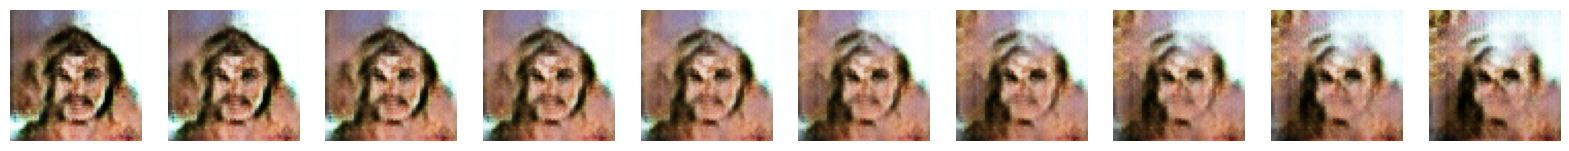

In [24]:
# Generate images for each interpolated point
interpolated_images = []
for point in interpolated_points:
    # Reshape the point and predict the image
    point = point.reshape(1, latent_dim)
    image = gan.generator.predict(point)[0]
    image = (image * 255).astype("uint8")  # Convert to uint8 format
    interpolated_images.append(image)

# Plot the interpolated images
plot_images(interpolated_images, n_interpolations)

### Saving Generated Images

In [26]:
from google.colab import files
import shutil
import os

# Define the directory containing the images
images_directory = '/content/'  

# Define the name for the zip file to be created
zip_file_name = 'images1.zip'

# Filter only PNG files in the directory
png_files = [file for file in os.listdir(images_directory) if file.endswith('.png')]

# Create a zip file containing only the PNG images
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for png_file in png_files:
        file_path = os.path.join(images_directory, png_file)
        zipf.write(file_path, os.path.basename(file_path))

# Download the zip file to local machine
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Training with 100 Epochs

In [37]:
epochs = 100  # Checking differences between 50 and 100 Epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
633/633 [==============================] - 58s 86ms/step - d_loss: 0.6321 - g_loss: 1.3244
Epoch 2/100
633/633 [==============================] - 55s 86ms/step - d_loss: 0.6394 - g_loss: 1.1414
Epoch 3/100
633/633 [==============================] - 55s 87ms/step - d_loss: 0.6178 - g_loss: 1.1566
Epoch 4/100
633/633 [==============================] - 55s 86ms/step - d_loss: 0.6590 - g_loss: 1.1523
Epoch 5/100
633/633 [==============================] - 55s 87ms/step - d_loss: 0.6187 - g_loss: 1.6630
Epoch 6/100
633/633 [==============================] - 54s 86ms/step - d_loss: 0.5959 - g_loss: 1.2217
Epoch 7/100
633/633 [==============================] - 55s 86ms/step - d_loss: 0.6034 - g_loss: 1.2645
Epoch 8/100
633/633 [==============================] - 55s 87ms/step - d_loss: 0.6065 - g_loss: 1.1774
Epoch 9/100
633/633 [==============================] - 56s 87ms/step - d_loss: 0.6343 - g_loss: 1.1808
Epoch 10/100
633/633 [==============================] - 55s 86ms/step - d

### Image Interpolation for 100 Epochs

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def interpolate_points(p1, p2, n_steps=10):
    """Interpolate between two points in latent space"""
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = []
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

def plot_images(images, n):
    """Plot a list of images"""
    plt.figure(figsize=(20, 4))
    for i, image in enumerate(images):
        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Generate two random points in the latent space
latent_dim = 128  # or whatever your latent dimension is
point1 = np.random.randn(latent_dim)
point2 = np.random.randn(latent_dim)

# Interpolate between these points
n_interpolations = 10
interpolated_points = interpolate_points(point1, point2, n_interpolations)

1/1 [==============================] - 0s 27ms/step


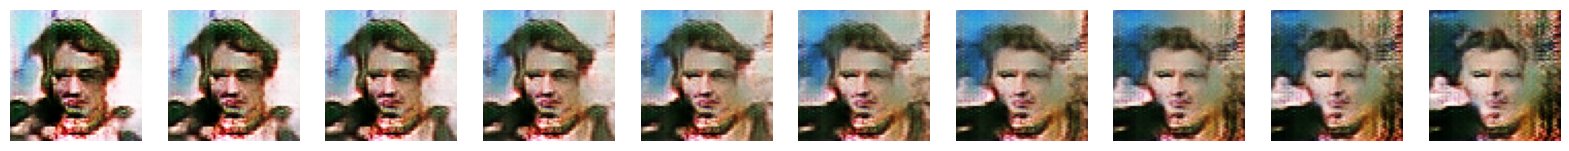

In [40]:
# Generate images for each interpolated point
interpolated_images = []
for point in interpolated_points:
    # Reshape the point and predict the image
    point = point.reshape(1, latent_dim)
    image = gan.generator.predict(point)[0]
    image = (image * 255).astype("uint8")  # Convert to uint8 format
    interpolated_images.append(image)

# Plot the interpolated images
plot_images(interpolated_images, n_interpolations)